# Power Outages
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the severity (number of customers, duration, or demand loss) of a major power outage.
    * Predict the cause of a major power outage.
    * Predict the number and/or severity of major power outages in the year 2020.
    * Predict the electricity consumption of an area.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction

- **Prediction Problem**:

    Utilize the condition of duration of outages, the cause of outages, consumption patterns of the state that happened outages, and geographical condition of the outages to predict whether or not the outage happened is severe.

    The problem is a classification problem, becaue we evaluate the severeness of outages by measuring whether the customers being affected in that outages surpassed the mean number of customers being affected in outages. Therefore, we consider a outage event is severe if the number of customers affected is greater than the mean number of customers, else not severe. 
    
    In our final model, our accuracy score on the test size is 0.81, which implies that 81 percent of outage whether is severe is predicted correctly by our model. we choose to use accuracy score instead of the F-1 score, because we have less ethical problem if we meet either false positives or false negatives in this scenario. Additionally, the standard of severe are not strictly depends on the number of people that being affected, and our standard is focused on the range of number of people affected, so if the severeness is true, it mainly indicates that the number of people being affected is relative high.
    

### Baseline Model

In our baseline model, we have two features. One is the variable "DEMAND.LOSS.MW" after taking log; and another variable is "CAUSE.CATEGORY".

`"DEMAND.LOSS.MW"` is a quantitative variable, and the higher the value, meaning the higher the loss of demand.

`"CAUSE.CATEGORY"` is a categorical variable, and it displays the category of outage.

In the baseline model, our accuracy score on training dataset is 0.84, and the accuracy score on testing dataset is 0.74. This score is not too slow and also not too high, which is fair, because we didn't do much engineer on features. Basically, this model reflects that the cause of outages is a good indicator of whether the number of affected is high. 


### Final Model

- **Engineer New Features**

    To improve our model's performance, we engineered few new features. Specifically, we used `pipe_poly` and `pipe_std` to create new features. The two mini pipelines first impute the missing value with the mean of the input columns, and then perform PolynomialFeatures and StandardScaler respectively. We imputated the missing values first to avoid `ValueError: Input contains NaN` that will interrupt later procedure. We decided to use PolynomialFeatures on `'DEMAND.LOSS.MW'` and `'POPULATION'` columns since we found that these column seems to have a nonlinear relationship with the outage severity. We decided to use StandardScaler on `'RES.SALES'`, `'COM.SALES'`, `'IND.SALES'`, and `'TOTAL.SALES'` columns since these columns have extremly large numbers (e.g. `'RES.SALES'` has a maximum value of 18620657.0). By standardizing them, we can reduce the effects of coulumns with large numbers to improve our prediction.
    
    
- **Search for the Best Model**

    After the preprocessing, we used a `RandomForestClassifier` since it has higher accuracy compared to the single decision tree and handels missing values well (we have multiple missing values in our columns). Then, we used a pipeline with `GridSearchCV` to find the model with the best hyperparameters. We considered `max_depth` and `min_samples_split` as our key parameters and input a list of possible value to find the best parameter, which is max_depth = 7 and min_sample_split =7. Then, we will have a higher accuracy score of 0.81.


### Fairness Evaluation

In this section, we choose `CLIMATE.CATEGORY` column to construct the interesting subset. We wanted to test this subset since we noticed that our model may predict normal cliamte better since we have more data with outages in normal climate. We dicided to use accuracy parity as our parity measure since we care about the accuaracy of our prediction rather than the proportion of prediction that predict the outage is severe. In fact, the severity proportion in the two subsets is probably different becuase in non-normal climate, there is a greater chance of severe weather which leads to severe outages. Thus, demographic parity is not a good choice in this case. 

To know whether our model predicts differently when the outage was happened in normal climate and in non-normal climate. We generated the following hyptheses:

- Null Hypothesis: our model is fair; the precision for the two subsets (normal climate VS non-normal climate) are roughly the same, the difference is only due to chance
- Alternative Hypothesis: our model is unfair; the precision for the normal climate subsets is higher than the precision of the non-normal climate subsets

We dicided to use a permuation test to test our hypthesis. We first split our data into outages with normal climate and non-normal climate, and compute the precision of each subset. We then subtract the normal climate precision with the non-normal cliamte precision to compute the signed observed difference. We then computed a list of signed precision difference between the two subsets through 1000 permutations. Since our p-value is 0.392 which is greater than 0.05, we fails to reject the null hypothesis that our model is fair.

# Code

In [176]:
#import pakages
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn import utils
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import metrics
from sklearn.pipeline import make_pipeline

In [1]:
#import pakages
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [2]:
#import pakages
from sklearn.model_selection import GridSearchCV

In [3]:
#read dataframe
df = pd.read_excel('outage.xlsx', skiprows = lambda x: x in [1])
df.head()

,variables,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,NaN,1,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
1,NaN,2,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
2,NaN,3,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
3,NaN,4,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
4,NaN,5,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


In [4]:
#read dataframe
new_df = df.copy()
new_df = (new_df[['YEAR', 'MONTH', 'U.S._STATE', 'NERC.REGION', 
                'CLIMATE.REGION',  'CLIMATE.CATEGORY', 'OUTAGE.START.DATE', 'OUTAGE.START.TIME',
                'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME', 'CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL',
                'OUTAGE.DURATION', 'DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED', 'RES.SALES', 'COM.SALES', 'IND.SALES',
                 'TOTAL.SALES', 'POPULATION', 'POPPCT_URBAN', 'POPDEN_RURAL', 'POPDEN_URBAN']]
         )
new_df.head()

,YEAR,MONTH,U.S._STATE,NERC.REGION,CLIMATE.REGION,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,OUTAGE.RESTORATION.DATE,OUTAGE.RESTORATION.TIME,...,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,RES.SALES,COM.SALES,IND.SALES,TOTAL.SALES,POPULATION,POPPCT_URBAN,POPDEN_RURAL,POPDEN_URBAN
0,2011,7.0,Minnesota,MRO,East North Central,normal,2011-07-01,17:00:00,2011-07-03,20:00:00,...,NaN,70000.0,2332915.0,2114774.0,2113291.0,6562520.0,5348119,73.27,18.2,2279.0
1,2014,5.0,Minnesota,MRO,East North Central,normal,2014-05-11,18:38:00,2014-05-11,18:39:00,...,NaN,NaN,1586986.0,1807756.0,1887927.0,5284231.0,5457125,73.27,18.2,2279.0
2,2010,10.0,Minnesota,MRO,East North Central,cold,2010-10-26,20:00:00,2010-10-28,22:00:00,...,NaN,70000.0,1467293.0,1801683.0,1951295.0,5222116.0,5310903,73.27,18.2,2279.0
3,2012,6.0,Minnesota,MRO,East North Central,normal,2012-06-19,04:30:00,2012-06-20,23:00:00,...,NaN,68200.0,1851519.0,1941174.0,1993026.0,5787064.0,5380443,73.27,18.2,2279.0
4,2015,7.0,Minnesota,MRO,East North Central,warm,2015-07-18,02:00:00,2015-07-19,07:00:00,...,250.0,250000.0,2028875.0,2161612.0,1777937.0,5970339.0,5489594,73.27,18.2,2279.0


In [264]:
#explore dataframe
new_df99 = new_df.drop(columns=['OUTAGE.START.DATE', 'OUTAGE.START.TIME',
                'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME','POPPCT_URBAN', 'POPDEN_RURAL', 'POPDEN_URBAN'])
new_df99.head()

,YEAR,MONTH,U.S._STATE,NERC.REGION,CLIMATE.REGION,CLIMATE.CATEGORY,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,RES.SALES,COM.SALES,IND.SALES,TOTAL.SALES,POPULATION
0,2011,7.0,Minnesota,MRO,East North Central,normal,severe weather,NaN,3060.0,NaN,70000.0,2332915.0,2114774.0,2113291.0,6562520.0,5348119
1,2014,5.0,Minnesota,MRO,East North Central,normal,intentional attack,vandalism,1.0,NaN,NaN,1586986.0,1807756.0,1887927.0,5284231.0,5457125
2,2010,10.0,Minnesota,MRO,East North Central,cold,severe weather,heavy wind,3000.0,NaN,70000.0,1467293.0,1801683.0,1951295.0,5222116.0,5310903
3,2012,6.0,Minnesota,MRO,East North Central,normal,severe weather,thunderstorm,2550.0,NaN,68200.0,1851519.0,1941174.0,1993026.0,5787064.0,5380443
4,2015,7.0,Minnesota,MRO,East North Central,warm,severe weather,NaN,1740.0,250.0,250000.0,2028875.0,2161612.0,1777937.0,5970339.0,5489594


severity

In [294]:
#create severety column
new_df99['CUS_SEV']=(new_df99['CUSTOMERS.AFFECTED']>=new_df99['CUSTOMERS.AFFECTED'].mean())#(
    #(new_df99['DEMAND.LOSS.MW']>=new_df99['DEMAND.LOSS.MW'].mean())
            #&(new_df99['OUTAGE.DURATION']>=new_df99['OUTAGE.DURATION'].mean()))

### Baseline Model

In [295]:
#split data to tain and test
X = new_df99.drop(columns=['CUSTOMERS.AFFECTED','CUS_SEV'])
y = new_df99['CUS_SEV']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25)
X_train

,YEAR,MONTH,U.S._STATE,NERC.REGION,CLIMATE.REGION,CLIMATE.CATEGORY,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,OUTAGE.DURATION,DEMAND.LOSS.MW,RES.SALES,COM.SALES,IND.SALES,TOTAL.SALES,POPULATION
244,2008,4.0,Texas,TRE,South,cold,severe weather,NaN,5595.0,NaN,7964564.0,8471717.0,8958318.0,25400068.0,24309039
0,2011,7.0,Minnesota,MRO,East North Central,normal,severe weather,NaN,3060.0,NaN,2332915.0,2114774.0,2113291.0,6562520.0,5348119
925,2011,8.0,New York,NPCC,Northeast,cold,severe weather,NaN,1.0,NaN,5406845.0,7322466.0,1195400.0,14159584.0,19523202
13,2011,5.0,Minnesota,MRO,East North Central,normal,intentional attack,vandalism,1322.0,0.0,1568544.0,1770802.0,1921812.0,5262668.0,5348119
871,2011,4.0,Delaware,RFC,Northeast,cold,intentional attack,vandalism,0.0,0.0,324759.0,321446.0,200015.0,846219.0,907916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,2011,7.0,Ohio,RFC,Central,normal,system operability disruption,NaN,352.0,206.0,5970787.0,4760078.0,4820523.0,15553889.0,11545442
105,2012,7.0,Michigan,RFC,East North Central,normal,severe weather,thunderstorm,2670.0,NaN,4366986.0,3838309.0,2796506.0,11002234.0,9886879
783,2011,9.0,New Jersey,RFC,Northeast,cold,intentional attack,vandalism,375.0,0.0,2682310.0,3409681.0,691446.0,6808089.0,8842934
1529,2011,12.0,North Dakota,MRO,West North Central,cold,public appeal,NaN,720.0,155.0,488853.0,438133.0,386693.0,1313678.0,685326


In [197]:
#mean imputation helper 
def mean_imputation(s):
    return s.fillna(s.mean())
mean_impute_transformer = FunctionTransformer(mean_imputation)
mean_impute_transformer.fit_transform(new_df['CUSTOMERS.AFFECTED']).isna().mean()

0.0

In [279]:
#baseline model
pipe_log = Pipeline([('fillna_mean', mean_impute_transformer), 
                 ('log', FunctionTransformer(np.log1p))])
preproc = ColumnTransformer(
    transformers = [
        ('log', pipe_log,['DEMAND.LOSS.MW']),
        ('one-hot', OneHotEncoder(handle_unknown='ignore'), ['CAUSE.CATEGORY'])
    ]
)
pl = Pipeline([
    ('preprocessor', preproc),
    ('dtree-cls', DecisionTreeClassifier(max_depth=7))
])

pl.fit(X_train, y_train)
pl.score(X_train, y_train)

0.8573913043478261

In [223]:
#test score
pl.score(X_test, y_test)
metrics.accuracy_score(y_test, y_pred)

0.7447916666666666

In [ ]:
# TODO

### Final Model

In [234]:
#final model
pipe_poly = Pipeline([('fillna_mean', mean_impute_transformer), 
                 ('polynomial', PolynomialFeatures(2))])
pipe_std = Pipeline([('fillna_mean', mean_impute_transformer), 
                 ('std', StandardScaler())])
preproc = ColumnTransformer(
    transformers = [
        ('one-hot', OneHotEncoder(handle_unknown='ignore'), ['U.S._STATE', 'NERC.REGION','CLIMATE.REGION','CLIMATE.CATEGORY','CAUSE.CATEGORY']),
        ('log',pipe_log, ['OUTAGE.DURATION']),
        ('std',pipe_std,['RES.SALES', 'COM.SALES', 'IND.SALES', 'TOTAL.SALES']),
        ('polyno',pipe_poly,[ 'DEMAND.LOSS.MW','POPULATION'])
    ]
)
from sklearn.pipeline import make_pipeline


0.8530434782608696

In [302]:
#perform grid search
clf1 = Pipeline([('prep', preproc), 
                ('grid', GridSearchCV(RandomForestClassifier(),
                        param_grid={'max_depth': [2, 3, 4, 5, 7, 9, 10],
                                 'min_samples_split': [2, 3, 5, 7, 9, 10, 15, 20],
                                 'criterion': ['gini', 'entropy']},
                                  cv=5))
                ])
clf1.fit(X_train, y_train)
clf1.predict(X_train)
clf1.score(X_train, y_train)

0.8495652173913043

In [304]:
#best para find
clf1.named_steps['grid'].best_params_

{'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 7}

In [308]:
#test score for final model
y_pred = clf1.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.8098958333333334

In [305]:
#confusion_matrix
y_pred = clf1.predict(X_test)
metrics.confusion_matrix(y_test, y_pred)

array([[300,   8],
       [ 65,  11]])

/Users/lisalei/opt/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


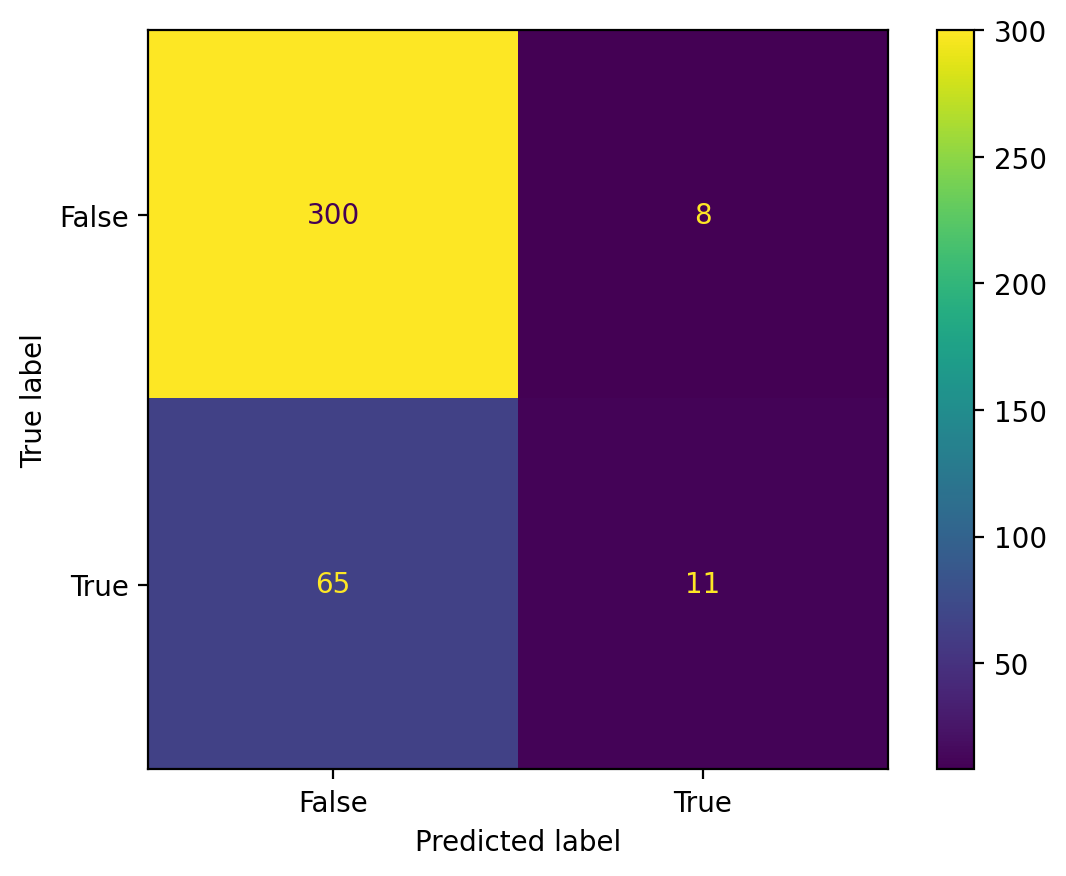

In [307]:
metrics.plot_confusion_matrix(clf1, X_test, y_test);

In [274]:
metrics.f1_score(y_test, clf.predict(X_test))

0.5766871165644172

### Fairness Evaluation

#### Fairness test

fairness: precision for normal weather vs precision for not normal weather
use a permutation test

In [311]:
#split data
df_normal = new_df99[new_df99['CLIMATE.CATEGORY']=='normal']
df_non_normal = new_df99[new_df99['CLIMATE.CATEGORY']!='normal']
X1 = df_normal.drop(columns=['CUSTOMERS.AFFECTED','CUS_SEV'])
y1 = df_normal['CUS_SEV']
weather_normal_sc = metrics.precision_score(y1,clf1.predict(X1))
X2 = df_non_normal.drop(columns=['CUSTOMERS.AFFECTED','CUS_SEV'])
y2 = df_non_normal['CUS_SEV']
weather_non_normal_sc = metrics.precision_score(y2,clf1.predict(X2))
obs_diff = weather_normal_sc-weather_non_normal_sc
obs_diff

0.058640373637778964

In [313]:
#obs_diff compute
df_normal = new_df99[new_df99['CLIMATE.CATEGORY']=='normal']
df_non_normal = new_df99[new_df99['CLIMATE.CATEGORY']!='normal']
X1 = df_normal.drop(columns=['CUSTOMERS.AFFECTED','CUS_SEV'])
y1 = df_normal['CUS_SEV']
weather_normal_sc = metrics.precision_score(y1,clf1.predict(X1))
X2 = df_non_normal.drop(columns=['CUSTOMERS.AFFECTED','CUS_SEV'])
y2 = df_non_normal['CUS_SEV']
weather_non_normal_sc = metrics.precision_score(y2,clf1.predict(X2))
obs_diff = weather_normal_sc-weather_non_normal_sc
obs_diff

0.058640373637778964

In [317]:
#permutation test
n_repetitions = 1000

differences = []
for _ in range(n_repetitions):
    
    # Step 1: Shuffle the weights
    shuffled_weather = (
        new_df99['CLIMATE.CATEGORY']
        .sample(frac=1)
        .reset_index(drop=True) # Be sure to reset the index! (Why?)
    )
    
    # Step 2: Put them in a DataFrame
    new_df99["shuffled_weather"] = shuffled_weather
    
    # Step 3: Compute the test statistic
    df_normal = new_df99[new_df99['shuffled_weather']=='normal']
    df_non_normal = new_df99[new_df99['shuffled_weather']!='normal']
    X1 = df_normal.drop(columns=['CUSTOMERS.AFFECTED','CUS_SEV'])
    y1 = df_normal['CUS_SEV']
    weather_normal_sc = metrics.precision_score(y1,clf1.predict(X1))
    X2 = df_non_normal.drop(columns=['CUSTOMERS.AFFECTED','CUS_SEV'])
    y2 = df_non_normal['CUS_SEV']
    weather_non_normal_sc = metrics.precision_score(y2,clf1.predict(X2))
    difference = weather_normal_sc-weather_non_normal_sc
    # Step 4: Store the result
    differences.append(difference)

In [318]:
#p-value
(differences>= obs_diff).mean()

0.392